# Atividade Final Big Data
## Analise de dados e Machine Learning com Spark

Obs: Otilização de colab

In [1]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 54.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=3c4587a8b3b75116114d6e341aa0c244dbbb2cb8886230f60ec9cb536d50df72
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

#Setup Imports

In [19]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
import random
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler



In [ ]:
sc = pyspark.SparkContext(appName='SparkSQL')

Utilizaremos o data set WINE encontrado no link: https://gist.github.com/tijptjik/9408623#file-wine-csv

Realizaremos a analise e tratamento de dados e posteriormente utilizaremos tecnicas de machine learning afim de classificar vinhos através de suas caracteristicas.

## Importação do data set através do spark

In [4]:
#iniciando o Spark
spark = SparkSession.builder.getOrCreate()

In [5]:
# importando o um arquivo csv

wine_df = spark.read.csv('file:/content/wine.csv', inferSchema=True, header=True)
wine_df.show(10)

+----+-------+----------+----+----+---+-------+----------+--------------------+-------+---------+----+----+-------+
|Wine|Alcohol|Malic.acid| Ash| Acl| Mg|Phenols|Flavanoids|Nonflavanoid.phenols|Proanth|Color.int| Hue|  OD|Proline|
+----+-------+----------+----+----+---+-------+----------+--------------------+-------+---------+----+----+-------+
|   1|  14.23|      1.71|2.43|15.6|127|    2.8|      3.06|                0.28|   2.29|     5.64|1.04|3.92|   1065|
|   1|   13.2|      1.78|2.14|11.2|100|   2.65|      2.76|                0.26|   1.28|     4.38|1.05| 3.4|   1050|
|   1|  13.16|      2.36|2.67|18.6|101|    2.8|      3.24|                 0.3|   2.81|     5.68|1.03|3.17|   1185|
|   1|  14.37|      1.95| 2.5|16.8|113|   3.85|      3.49|                0.24|   2.18|      7.8|0.86|3.45|   1480|
|   1|  13.24|      2.59|2.87|21.0|118|    2.8|      2.69|                0.39|   1.82|     4.32|1.04|2.93|    735|
|   1|   14.2|      1.76|2.45|15.2|112|   3.27|      3.39|              

##Verificação estatistica do data frame

In [6]:
print(f'Quantidade de linhas {wine_df.count()}')
print(f'Quantidade de colunas {len(wine_df.columns)}')
print('Estatisticas gerais')
wine_df.describe().show()


Quantidade de linhas 178
Quantidade de colunas 14
Estatisticas gerais
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-----------------+
|summary|              Wine|           Alcohol|        Malic.acid|               Ash|              Acl|                Mg|           Phenols|        Flavanoids|Nonflavanoid.phenols|           Proanth|        Color.int|                Hue|                OD|          Proline|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-----------------+
|  count|               178|               178|               178|               178|              178

### Verificando o balanceamento do dataset

In [7]:
#por tabela
wine_grupo = wine_df.groupBy('Wine').count()
wine_grupo.show()

+----+-----+
|Wine|count|
+----+-----+
|   1|   59|
|   3|   48|
|   2|   71|
+----+-----+



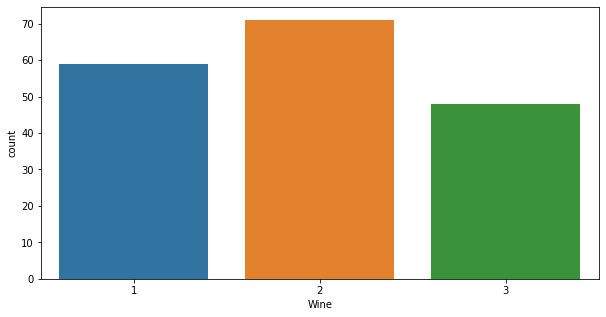

In [8]:
# graficamente
wine_grupo_pd = wine_grupo.toPandas()
plt.figure(figsize=(10,5))
_= sns.barplot(x='Wine', y='count', data=wine_grupo_pd)

##Verificando correlação

Utlização de visão grafica das variaveis para ter mais clareza na escolha das melhores features, nesse ponto escolheremos o que tem uma certa correlação para que seja possível retirar um apredizado com os algoritmos de Machine Learning

In [9]:
list_columns = ['Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols', 'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline' ]


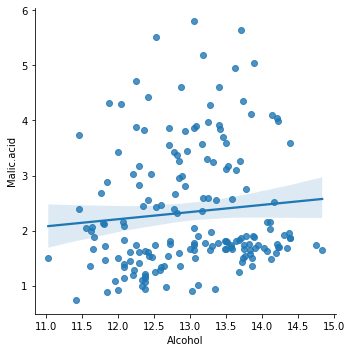

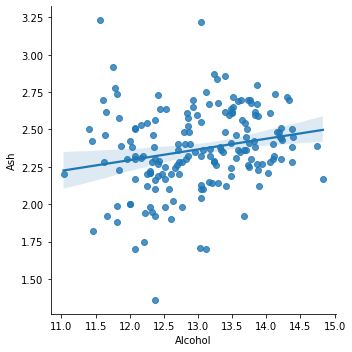

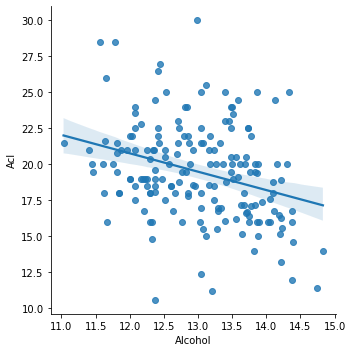

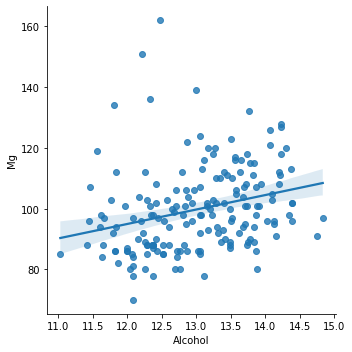

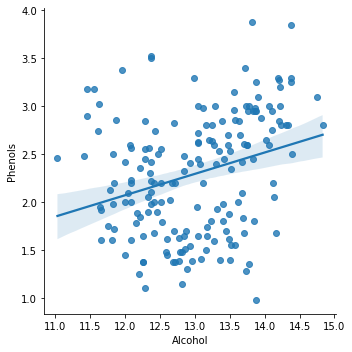

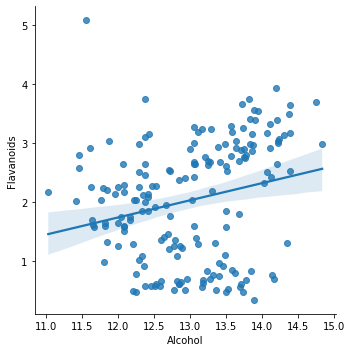

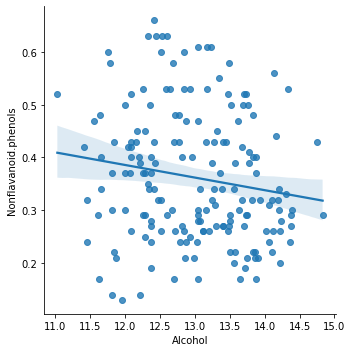

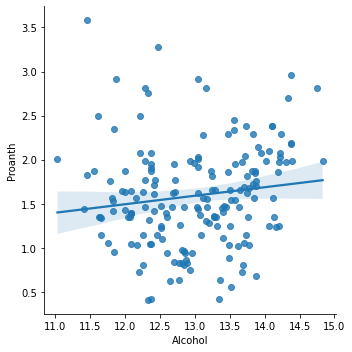

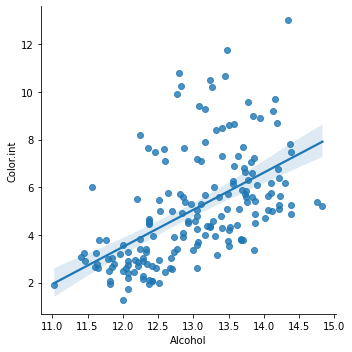

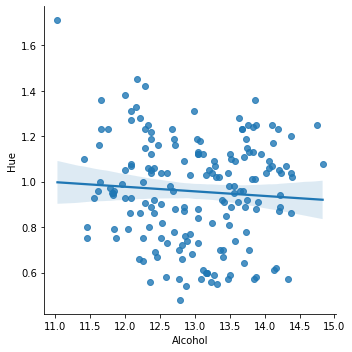

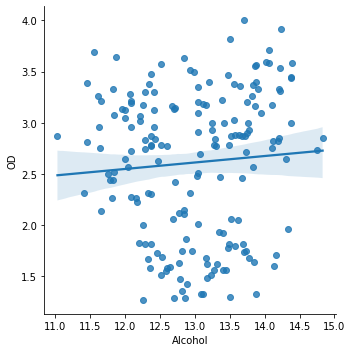

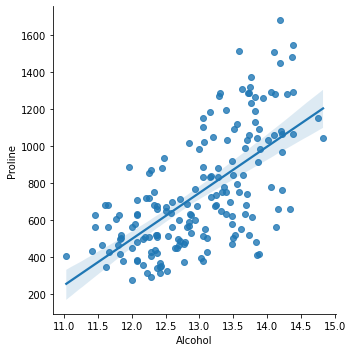

In [10]:
wine_pd = wine_df.toPandas()

for column in list_columns:
    sns.lmplot(x='Alcohol', y=column, data=wine_pd)

# Transformações

### Escolhendo as colunas que iremos trabalhar 

Nesse ponto deixamos somente as colunas necessárias para o aprendizado

In [11]:
final_list = ['Alcohol','Ash', 'Acl', 'Mg', 'Phenols', 'Flavanoids', 'Proanth', 'Proline' ]

wine_df = wine_df.select('Wine', *final_list)
wine_df.show()

+----+-------+----+----+---+-------+----------+-------+-------+
|Wine|Alcohol| Ash| Acl| Mg|Phenols|Flavanoids|Proanth|Proline|
+----+-------+----+----+---+-------+----------+-------+-------+
|   1|  14.23|2.43|15.6|127|    2.8|      3.06|   2.29|   1065|
|   1|   13.2|2.14|11.2|100|   2.65|      2.76|   1.28|   1050|
|   1|  13.16|2.67|18.6|101|    2.8|      3.24|   2.81|   1185|
|   1|  14.37| 2.5|16.8|113|   3.85|      3.49|   2.18|   1480|
|   1|  13.24|2.87|21.0|118|    2.8|      2.69|   1.82|    735|
|   1|   14.2|2.45|15.2|112|   3.27|      3.39|   1.97|   1450|
|   1|  14.39|2.45|14.6| 96|    2.5|      2.52|   1.98|   1290|
|   1|  14.06|2.61|17.6|121|    2.6|      2.51|   1.25|   1295|
|   1|  14.83|2.17|14.0| 97|    2.8|      2.98|   1.98|   1045|
|   1|  13.86|2.27|16.0| 98|   2.98|      3.15|   1.85|   1045|
|   1|   14.1| 2.3|18.0|105|   2.95|      3.32|   2.38|   1510|
|   1|  14.12|2.32|16.8| 95|    2.2|      2.43|   1.57|   1280|
|   1|  13.75|2.41|16.0| 89|    2.6|    

## verificando valores nulos, caso haja serão eliminados

In [12]:
print(wine_df.count())
wine_df = wine_df.distinct() \
                                .filter(wine_df['Alcohol'].isNotNull()) \
                                .filter(wine_df['Ash'].isNotNull()) \
                                .filter(wine_df['Acl'].isNotNull()) \
                                .filter(wine_df['Mg'].isNotNull()) \
                                .filter(wine_df['Phenols'].isNotNull()) \
                                .filter(wine_df['Flavanoids'].isNotNull()) \
                                .filter(wine_df['Proanth'].isNotNull()) \
                                .filter(wine_df['Proline'].isNotNull())

print(wine_df.count())

178
178


>>> Vemos que não temos nenhum valor nulo no dataset


## Normalizando os dados

Iremos normalizar os dados utilizando min max scaler para deixar os dados do dataset com uma escala melhor.

In [14]:
def min_max_norm(df, cols):
    for col in cols:
        max_value = df.agg({col:'max'}).collect()[0][0]
        min_value = df.agg({col:'min'}).collect()[0][0]
        new_column = col+'_scaled'
        df = df.withColumn(new_column, (df[col] - min_value) / (max_value - min_value))
    return df

wine_df_mm = min_max_norm(wine_df, final_list)

> Após a normalização iremos excluir as colunas originais deixando apenas as colunas normalizadas

In [16]:
wine_df_mm = wine_df_mm.drop(*['Alcohol','Ash', 'Acl', 'Mg', 'Phenols', 'Flavanoids', 'Proanth', 'Proline'])
wine_df_mm.show()

+----+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+
|Wine|     Alcohol_scaled|         Ash_scaled|         Acl_scaled|          Mg_scaled|     Phenols_scaled|   Flavanoids_scaled|     Proanth_scaled|      Proline_scaled|
+----+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+
|   2| 0.5315789473684213| 0.5133689839572192| 0.6134020618556701|0.16304347826086957|0.23103448275862068| 0.26371308016877637| 0.3817034700315458| 0.16904422253922968|
|   3| 0.5394736842105264|   0.53475935828877| 0.5618556701030929| 0.4673913043478261| 0.1482758620689655|  0.2215189873417721| 0.2302839116719243| 0.19400855920114124|
|   2|0.38947368421052636|0.33155080213903737| 0.5103092783505155|0.16304347826086957|0.42068965517241386| 0.33333333333333326|0.33753943217665616|  0.2810

### transformando as features em um único vetor, para ser compativel com o padrão utilizado pelo spark.

In [21]:
wine_df_mm.printSchema()
cols_to_use = ['Alcohol_scaled','Ash_scaled', 'Acl_scaled', 'Mg_scaled', 'Phenols_scaled', 'Flavanoids_scaled', 'Proanth_scaled', 'Proline_scaled']

vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
wine_vec = vec.transform(wine_df_mm)
wine_vec.select('features', 'Wine').show(truncate=False)

root
 |-- Wine: integer (nullable = true)
 |-- Alcohol_scaled: double (nullable = true)
 |-- Ash_scaled: double (nullable = true)
 |-- Acl_scaled: double (nullable = true)
 |-- Mg_scaled: double (nullable = true)
 |-- Phenols_scaled: double (nullable = true)
 |-- Flavanoids_scaled: double (nullable = true)
 |-- Proanth_scaled: double (nullable = true)
 |-- Proline_scaled: double (nullable = true)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|features                                                                                                                                                       |Wine|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|[0.5315789473684213,0.5133689839572192,0.6134020618556701,0.16304347826086957,0.23103448275862068

### Avaliando modelo de árvore de decisão

---



In [22]:
#dividir em treino/teste
wine_train, wine_test = wine_vec.randomSplit([0.8,0.2], seed=123)

print('Rodando o modelo e vendo o resultado')
wine_model_dt = DecisionTreeClassifier(featuresCol='features', labelCol='Wine')
preds_dt_wine = wine_model_dt.fit(wine_train).transform(wine_test)
preds_dt_wine.select('Wine', 'prediction', 'probability').show(truncate=False)

print('Matriz de confusão')
preds_dt_wine.groupBy('Wine', 'prediction').count().show()

Rodando o modelo e vendo o resultado
+----+----------+-----------------+
|Wine|prediction|probability      |
+----+----------+-----------------+
|3   |1.0       |[0.0,0.5,0.5,0.0]|
|2   |2.0       |[0.0,0.0,1.0,0.0]|
|2   |2.0       |[0.0,0.0,1.0,0.0]|
|2   |2.0       |[0.0,0.0,1.0,0.0]|
|3   |3.0       |[0.0,0.0,0.0,1.0]|
|2   |2.0       |[0.0,0.0,1.0,0.0]|
|1   |1.0       |[0.0,1.0,0.0,0.0]|
|3   |2.0       |[0.0,0.0,1.0,0.0]|
|2   |2.0       |[0.0,0.0,1.0,0.0]|
|1   |1.0       |[0.0,1.0,0.0,0.0]|
|2   |2.0       |[0.0,0.0,1.0,0.0]|
|3   |3.0       |[0.0,0.0,0.0,1.0]|
|1   |1.0       |[0.0,1.0,0.0,0.0]|
|3   |3.0       |[0.0,0.0,0.0,1.0]|
|2   |2.0       |[0.0,0.0,1.0,0.0]|
|1   |1.0       |[0.0,1.0,0.0,0.0]|
|2   |2.0       |[0.0,0.0,1.0,0.0]|
|3   |3.0       |[0.0,0.0,0.0,1.0]|
|2   |3.0       |[0.0,0.0,0.0,1.0]|
|1   |1.0       |[0.0,1.0,0.0,0.0]|
+----+----------+-----------------+
only showing top 20 rows

Matriz de confusão
+----+----------+-----+
|Wine|prediction|count|
+----+

In [23]:
multi_eval = MulticlassClassificationEvaluator().setLabelCol('Wine')
prec_dt_wine = multi_eval.evaluate(preds_dt_wine, {multi_eval.metricName: 'weightedPrecision'})
recall_dt_wine = multi_eval.evaluate(preds_dt_wine, {multi_eval.metricName: 'weightedRecall'})

bin_eval = BinaryClassificationEvaluator().setLabelCol('Wine')
AUC_dt_wine = bin_eval.evaluate(preds_dt_wine, {bin_eval.metricName:'areaUnderROC'})

print(f'Precision: {prec_dt_wine}')
print(f'Recall: {recall_dt_wine}')
print(f'AUC: {AUC_dt_wine}')

Precision: 0.8926640926640927
Recall: 0.8918918918918919
AUC: 1.0


### Avaliando modelo logisticRegression

In [24]:
logrec_model = LogisticRegression(featuresCol='features', labelCol='Wine')
preds_log_wine = logrec_model.fit(wine_train).transform(wine_test)
preds_log_wine.groupBy('Wine', 'prediction').count().show()

multi_eval = MulticlassClassificationEvaluator().setLabelCol('Wine')
prec_log_wine = multi_eval.evaluate(preds_log_wine, {multi_eval.metricName: 'weightedPrecision'})
recall_log_wine = multi_eval.evaluate(preds_log_wine, {multi_eval.metricName: 'weightedRecall'})

bin_eval = BinaryClassificationEvaluator().setLabelCol('Wine')
AUC_log_wine = bin_eval.evaluate(preds_log_wine, {bin_eval.metricName:'areaUnderROC'})

print(f'Precision: {prec_log_wine}')
print(f'Recall: {recall_log_wine}')
print(f'AUC: {AUC_log_wine}')


+----+----------+-----+
|Wine|prediction|count|
+----+----------+-----+
|   3|       2.0|    1|
|   3|       3.0|   12|
|   2|       2.0|   15|
|   1|       1.0|    9|
+----+----------+-----+

Precision: 0.9746621621621621
Recall: 0.972972972972973
AUC: 1.0


### Conclusão: Podemos observar que para esse conjunto de dados o algoritmo de machine learning baseado em regressão logistica se deu melhor e obteve melhores resultados de Precisão e Recall.